# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# Import supplementary visualizations code visuals.py
import visuals as vs

# Ignore warning being shown for deprecations
import warnings
warnings.filterwarnings('ignore')

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


### Attribute Information:

* FRESH: annual spending (m.u.) on fresh products (Continuous); 
* MILK: annual spending (m.u.) on milk products (Continuous); 
* GROCERY: annual spending (m.u.) on grocery products (Continuous); 
* FROZEN: annual spending (m.u.) on frozen products (Continuous) 
* DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
* DELICATESSEN: annual spending (m.u.) on and delicatessen products (Continuous); 

## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [4]:
# Display a description of the dataset
display(data.describe())

Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper  Delicatessen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [5]:
# Select three indices of your choice you wish to sample from the dataset 
indices = [8,53,289]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0   5963   3648     6192     425              1716           750
1    491  10473    11532     744              5611           224
2  42786    286      471    1388                32            22

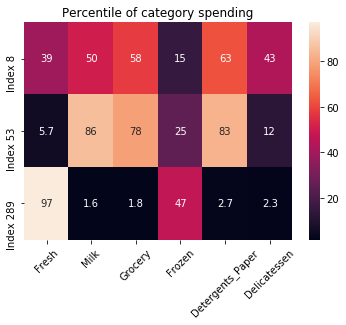

In [6]:
def plot_heatmap_of_samples():
    # [pandas.DataFrame.iloc](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.iloc.html)
    pcts = 100. * data.rank(axis=0, pct=True).iloc[indices].round(decimals=3)

    sns.heatmap(pcts, yticklabels=['Index ' + str(x) for x in indices], annot=True)
    plt.title('Percentile of category spending')
    plt.xticks(rotation=45, ha='center');

plot_heatmap_of_samples()

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?

**Hint:** Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant. You can use the mean values for reference to compare your samples with. The mean values are as follows:

* Fresh: 12000.2977
* Milk: 5796.2
* Grocery: 7951.3
* Detergents_paper: 2881.4
* Delicatessen: 1524.8

Knowing this, how do your samples compare? Does that help in driving your insight into what kind of establishments they might be? 


**Answer:**

* **Index 8** - The first sample above at index 8 has a below mean amount for each category and a small amount of frozen. It does however have a reasonable amount of each category so could be a small retail shop that sells a mixture of each category but only a relatively small amount of frozen products.

* **Index 53** - The second sample above at index 53 has a below average amount of fresh food and a high amount of milk with a high usage of paper. This suggests that it has a high throughput and could be a cafe.

* **Index 289** - The third sample at index 289 is likely a restaraunt as it has a high amount of fresh food significantly above the mean and a reasonable amount of frozen that is still below the mean. The amount in the other category is significantly below the mean further strengthening the proposal that this is a restaraunt and not a retail shop. 

Note: as the features of the data are highly right-skwewed; describing the data in terms of the percentiles above, in the heatmap, would be more representative with hindsight and futher analysis. 

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [8]:
# [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html)
new_data = data.drop('Grocery', axis=1)

# TODO: Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, data['Grocery'], test_size=0.25, random_state=0)

# TODO: Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print("Score for Grocery: {:,.4f}".format(score))

Score for Grocery: 0.6028


### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data. If you get a low score for a particular feature, that lends us to beleive that that feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

**Answer:**

I attempted to predict the feature **Grocery**. An `R^2` score of 0.60 was predicted. 

`R-2` is a statistical measure of how close the data is to the fitted regression line generated in this case by the decision tree regressor.  A positive score of 0.60 signifies that that the data can be used to predict to a reasonable level the Grocery feature. This feature is likely not as important as other features to make predictions. An important feature would have a low or negative `R^2` score as the data is unlikely to be able to predict this feature as this feature is important feature that itself is needed  to make predictions. 

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

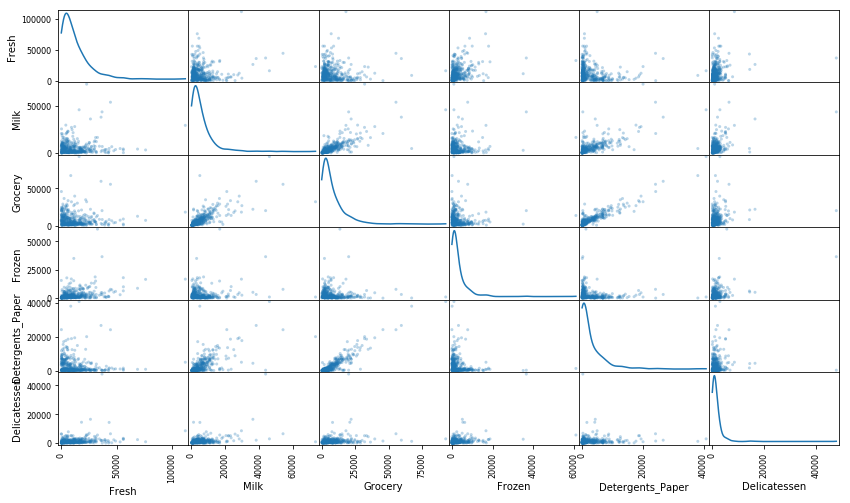

In [9]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

**Hint:** Is the data normally distributed? Where do most of the data points lie? You can use [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to get the feature correlations and then visualize them using a [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html) (the data that would be fed into the heatmap would be the correlation values, for eg: `data.corr()`) to gain further insight.

In [10]:
# Reference: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html
data.corr()

Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Fresh             1.000000  0.100510 -0.011854  0.345881         -0.101953   
Milk              0.100510  1.000000  0.728335  0.123994          0.661816   
Grocery          -0.011854  0.728335  1.000000 -0.040193          0.924641   
Frozen            0.345881  0.123994 -0.040193  1.000000         -0.131525   
Detergents_Paper -0.101953  0.661816  0.924641 -0.131525          1.000000   
Delicatessen      0.244690  0.406368  0.205497  0.390947          0.069291   

                  Delicatessen  
Fresh                 0.244690  
Milk                  0.406368  
Grocery               0.205497  
Frozen                0.390947  
Detergents_Paper      0.069291  
Delicatessen          1.000000

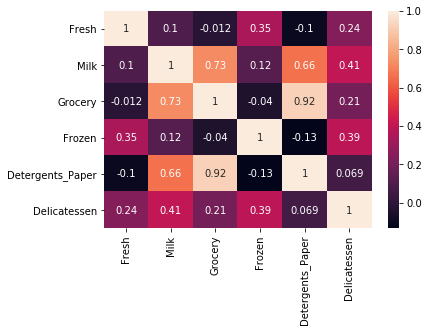

In [11]:
corr_heatmap = sns.heatmap(data.corr(), annot=True)

### Normality

I also wanted explored the normality of the original data using a combination of Histograms and Normal Probability plots.

* **Skewness** - this is a measure of symmetry of the dataset. Skewness is the absence of symmetry. 
* **Kurtosis** - this is a measure of whether the dataset is heavily tailed relative to a normal distribution and therefore has outliers. 

In a Normal Probability plot the data is plotted against a theoretical normal distribution. A dataset that is normally distribution should fit this straight line. 

* [Ref 1](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python), [Ref 2](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm)

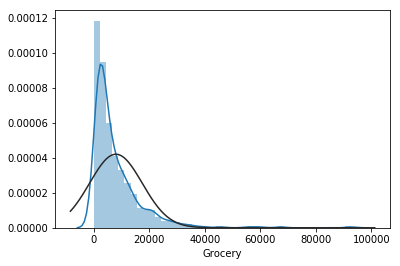

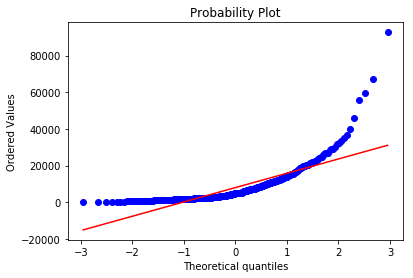

In [12]:
#histogram and normal probability plot
sns.distplot(data['Grocery'], fit=norm);
fig = plt.figure()
res = stats.probplot(data['Grocery'], plot=plt)

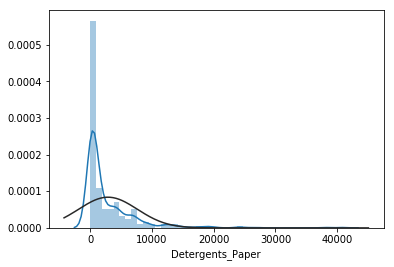

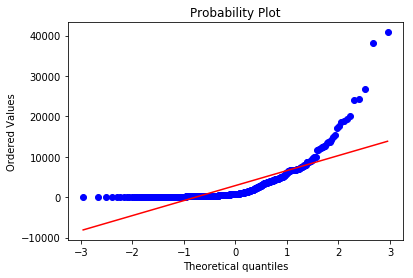

In [13]:
sns.distplot(data['Detergents_Paper'], fit=norm);
fig = plt.figure()
res = stats.probplot(data['Detergents_Paper'], plot=plt)

**Answer:**

Exploring the normality of the individual variables shows that the data is not normally distributed and we can see examples of right-skewness [Ref](http://www.statisticshowto.com/pearson-mode-skewness/). From the scatter plots we can see that there a number of outliers in the data based on the distribution of the points. The data clusters around 0 showing little correlation for certain pairs. 

* The strongest correlation from both the heatmap and the scatter plots is between `Detergents_paper` and `Grocery` (0.92)
* `Milk` and `Grocery` show the second largest correlation (0.73)
* `Milk` and `Detergent_Paper` show the third largest correlation (0.66)

This fits with the analysis of the relevance of the feature Grocery above. The high `R^2` is reflects in the fact that Grocery shows a high correlation with `Detergents_Paper` and `Milk` in the correlation analysis above. We can see in analysis above that there the data does not follow a normal distribution and exhibits a hig degress of right-skewness. 

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

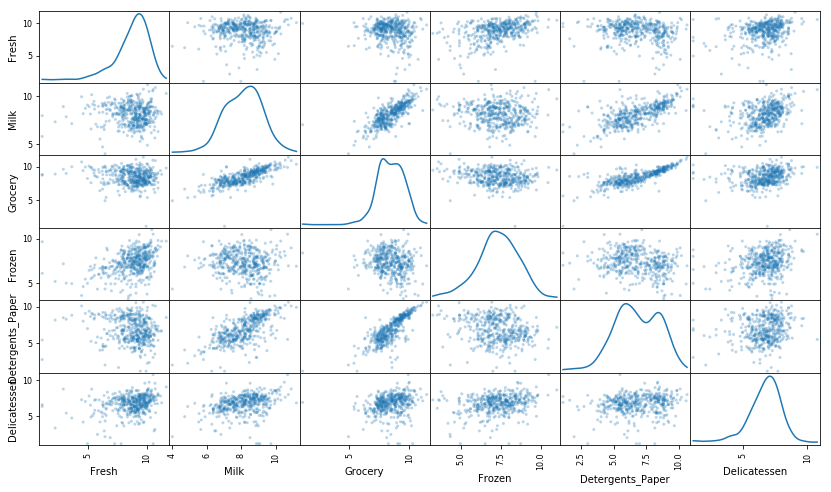

In [14]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [15]:
# Display the log-transformed sample data
display(log_samples)

Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0   8.693329  8.201934  8.731013  6.052089          7.447751      6.620073
1   6.196444  9.256556  9.352881  6.612041          8.632484      5.411646
2  10.663966  5.655992  6.154858  7.235619          3.465736      3.091042

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [16]:
import collections

# OPTIONAL: Select the indices for data points you wish to remove
outliers_array = []

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    outliers = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(outliers)
    outliers_array.extend(outliers.index.values)

counter = collections.Counter(outliers_array)
# print(counter)

outliers_to_remove = [x[0] for x in counter.items() if x[1] >= 2]
print("Data points considered outlier for more than 1 feature: {}".format(outliers_to_remove))
          
# Remove the outliers where it is an outliers in more than 1 feature only
good_data = log_data.drop(outliers_to_remove).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


Fresh       Milk    Grocery    Frozen  Detergents_Paper  Delicatessen
65   4.442651   9.950323  10.732651  3.583519         10.095388      7.260523
66   2.197225   7.335634   8.911530  5.164786          8.151333      3.295837
81   5.389072   9.163249   9.575192  5.645447          8.964184      5.049856
95   1.098612   7.979339   8.740657  6.086775          5.407172      6.563856
96   3.135494   7.869402   9.001839  4.976734          8.262043      5.379897
128  4.941642   9.087834   8.248791  4.955827          6.967909      1.098612
171  5.298317  10.160530   9.894245  6.478510          9.079434      8.740337
193  5.192957   8.156223   9.917982  6.865891          8.633731      6.501290
218  2.890372   8.923191   9.629380  7.158514          8.475746      8.759669
304  5.081404   8.917311  10.117510  6.424869          9.374413      7.787382
305  5.493061   9.468001   9.088399  6.683361          8.271037      5.351858
338  1.098612   5.808142   8.856661  9.655090          2.708050      6.309918
353  4.762174   8.742574   9.961898  5.429346          9.069007      7.013016
355  5.247024   6.588926   7.606885  5.501258          5.214936      4.844187
357  3.610918   7.150701  10.011086  4.919981          8.816853      4.700480
412  4.574711   8.190077   9.425452  4.584967          7.996317      4.127134

Data points considered outliers for the feature 'Milk':


Fresh       Milk    Grocery    Frozen  Detergents_Paper  Delicatessen
86   10.039983  11.205013  10.377047  6.894670          9.906981      6.805723
98    6.220590   4.718499   6.656727  6.796824          4.025352      4.882802
154   6.432940   4.007333   4.919981  4.317488          1.945910      2.079442
356  10.029503   4.897840   5.384495  8.057377          2.197225      6.306275

Data points considered outliers for the feature 'Grocery':


Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
75   9.923192  7.036148  1.098612  8.390949          1.098612      6.882437
154  6.432940  4.007333  4.919981  4.317488          1.945910      2.079442

Data points considered outliers for the feature 'Frozen':


Fresh      Milk    Grocery     Frozen  Detergents_Paper  Delicatessen
38    8.431853  9.663261   9.723703   3.496508          8.847360      6.070738
57    8.597297  9.203618   9.257892   3.637586          8.932213      7.156177
65    4.442651  9.950323  10.732651   3.583519         10.095388      7.260523
145  10.000569  9.034080  10.457143   3.737670          9.440738      8.396155
175   7.759187  8.967632   9.382106   3.951244          8.341887      7.436617
264   6.978214  9.177714   9.645041   4.110874          8.696176      7.142827
325  10.395650  9.728181   9.519735  11.016479          7.148346      8.632128
420   8.402007  8.569026   9.490015   3.218876          8.827321      7.239215
429   9.060331  7.467371   8.183118   3.850148          4.430817      7.824446
439   7.932721  7.437206   7.828038   4.174387          6.167516      3.951244

Data points considered outliers for the feature 'Detergents_Paper':


Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
75   9.923192  7.036148  1.098612  8.390949          1.098612      6.882437
161  9.428190  6.291569  5.645447  6.995766          1.098612      7.711101

Data points considered outliers for the feature 'Delicatessen':


Fresh       Milk    Grocery     Frozen  Detergents_Paper  \
66    2.197225   7.335634   8.911530   5.164786          8.151333   
109   7.248504   9.724899  10.274568   6.511745          6.728629   
128   4.941642   9.087834   8.248791   4.955827          6.967909   
137   8.034955   8.997147   9.021840   6.493754          6.580639   
142  10.519646   8.875147   9.018332   8.004700          2.995732   
154   6.432940   4.007333   4.919981   4.317488          1.945910   
183  10.514529  10.690808   9.911952  10.505999          5.476464   
184   5.789960   6.822197   8.457443   4.304065          5.811141   
187   7.798933   8.987447   9.192075   8.743372          8.148735   
203   6.368187   6.529419   7.703459   6.150603          6.860664   
233   6.871091   8.513988   8.106515   6.842683          6.013715   
285  10.602965   6.461468   8.188689   6.948897          6.077642   
289  10.663966   5.655992   6.154858   7.235619          3.465736   
343   7.431892   8.848509  10.177932   7.283448          9.646593   

     Delicatessen  
66       3.295837  
109      1.098612  
128      1.098612  
137      3.583519  
142      1.098612  
154      2.079442  
183     10.777768  
184      2.397895  
187      1.098612  
203      2.890372  
233      1.945910  
285      2.890372  
289      3.091042  
343      3.610918

Data points considered outlier for more than 1 feature: [65, 66, 128, 154, 75]


In [17]:
# Confirm removal of the 5 outliers 
good_data.describe()

Fresh        Milk     Grocery      Frozen  Detergents_Paper  \
count  435.000000  435.000000  435.000000  435.000000        435.000000   
mean     8.766671    8.128376    8.460236    7.324601          6.799008   
std      1.423133    1.062911    1.046108    1.261038          1.684562   
min      1.098612    4.718499    5.384495    3.218876          1.098612   
25%      8.073389    7.364809    7.676010    6.647029          5.560615   
50%      9.055439    8.198089    8.467372    7.340187          6.700731   
75%      9.737108    8.877379    9.274768    8.177371          8.277644   
max     11.627601   11.205013   11.437986   11.016479         10.617099   

       Delicatessen  
count    435.000000  
mean       6.694349  
std        1.261066  
min        1.098612  
25%        6.019808  
50%        6.874198  
75%        7.509609  
max       10.777768

### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

** Hint: ** If you have datapoints that are outliers in multiple categories think about why that may be and if they warrant removal. Also note how k-means is affected by outliers and whether or not this plays a factor in your analysis of whether or not to remove them.

**Answer:**

There are 5 outliers that are considered outliers for more than one feature based on the analysis above at these indicies ` [65, 66, 128, 154, 75]`

There were many more points that were considered an outlier for one feature however only the data points with outliers for multiple feature have been removed as these are more significant outliers and would have more impact on the analysis. 

K-means is generally sensitive to outliers because we take the distance between points therefore we would want to remove outliers as it is sensitive to these outliers. The outliers would impact the definition of the clusters and could mis-represent the structure of the data.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

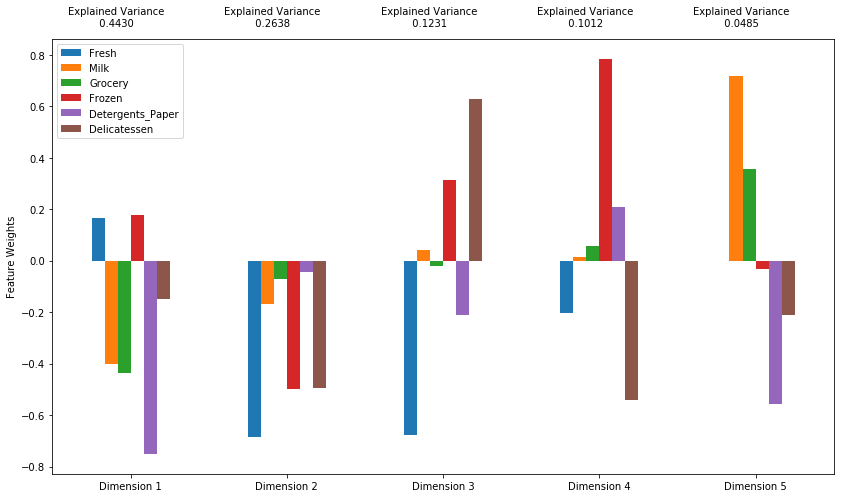

In [18]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=5).fit(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

In [19]:
print(pca.explained_variance_ratio_.round(2))

[0.44 0.26 0.12 0.1  0.05]


**Answer:**

The `explained_variance_ratio_` shown in the results above tells you how much information (variance) can be attributed to each of the principal components. [Ref 2](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60).

The 1st principal components explains **44.2%** while the second components explains **27.7%** therefore the combined total variance explained by the first two PC is **71.9%**. 

The 3rd PC = **11.6%** and the 4th PC = **10.0%** therefore the total variance explained by the first four PC is **93.5%**

In the visualisation generated above a high positive or negative value of the feature weight indicates that the feature contributes a lot to the explained variance. 

* The **1st PC** explains the variance in Detergent_paper (weight ~0.8) and Grocery and Milk are also more significant (weight ~0.4). This could represents customer spending on daily goods at a retailer.
* The **2nd PC** explains the variance in Fresh (weight ~0.7), Frozen (weight ~0.5) and Delicatessen (weight ~0.5). This could represent the customer spending by the restaraunt trade which purchases a large amount of these combinations. It's clear from the data that Fresh ingredients cost more therefore this PC is associate with higer purchasing of Fresh good in addition to Frozen and Delicatessen. 
* The **3rd PC** explains the variance in Fresh (weight ~0.7), Delicatessen (weight ~0.6) and Frozen (weight ~0.3). This is like a cafe/restaraunt but with higher purchasing of Delicatessen products.
* The **4th PC** explains the variance in Frozen (weight ~0.8), Delicatessen (weight ~0.6). This again could be another Cafe/Restaurant but one that because of the type of Cafe/Restaurant purchases more of this combination.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [20]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5
0      -0.8636       0.6650      -0.5376      -0.7922      -0.1551
1      -2.5869       2.4239       0.3501       1.1095       0.4039
2       5.3491       1.2417      -2.9268       0.6380       0.0147

### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [21]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [22]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

Dimension 1  Dimension 2
0      -0.8636       0.6650
1      -2.5869       2.4239
2       5.3491       1.2417

## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

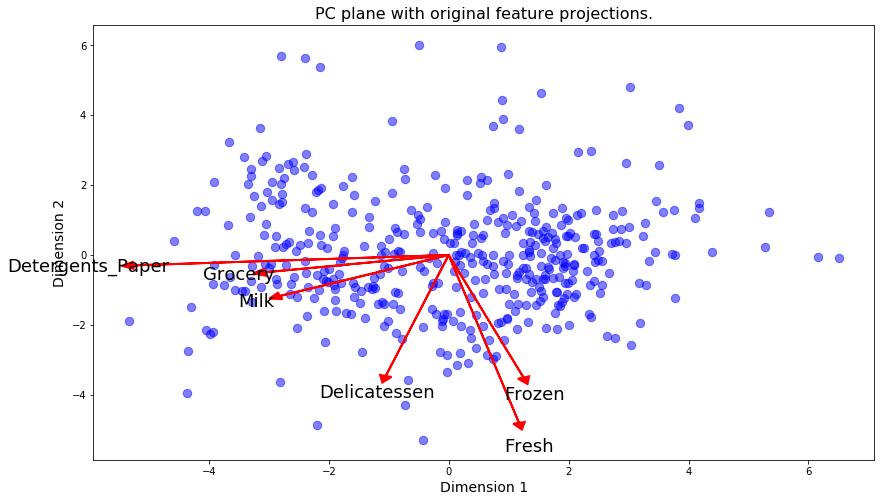

In [23]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

#### Answer

`Detergent_Paper`, `Grocery` and `Milk` are shown to be strongly correlated for Dimension 1. This matches the plot above which have showed the same correlation based on the feature weights. 

The same applies for `Delicatessen`, `Frozen` and `Fresh` which are shown to be correlated for Dimension 2. This again matches the plot above based on the feature weights. 

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

**Answer:**

**Advantages of K-means**
* Easy to implement and computationally fast. 

**Disadvantages of K-means**: [Ref 3](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)
* K-means can be sensitive to outliers.
* Its lack of flexibility in cluster shape and lack of probabilistic cluster assignment. k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters.
* Generally need to define the number of clusters or determine a way to determine the optimum number of clusters. 

**Advantages of GMM: ** 
[Ref 4](https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/mixture.html)
* Flexibility in choosing the component distribution
* Obtain a density estimation for each cluster
* Capable of a “soft” classification.


**Distadvantages of GMM:**  [Ref 5](http://scikit-learn.org/stable/modules/mixture.html)
* Number of components - held-out data or other methods are required to determine how many components to use. 
* Singularities - if there is insufficient points per mixture then estimating the covariance matrices becomes difficult and the the GMM algortithm may diverege.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [24]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# TODO: Apply your clustering algorithm of choice to the reduced data 
clusterer = GaussianMixture(n_components=2).fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
print("Score: {:,.4f}".format(score))

Score: 0.4219


### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer:**

Output of the silhouette scores for the different clusters below:

| Number of Clusters | Silhouette Score |
| --- | --- |
| 2    | 0.4219  |  
| 3    | 0.3042  |  
| 4    | 0.3333  |  
| 5    | 0.2861 |  

The highest Silhouette score was found for **2 clusters**. 

Note: a further bit of work here could have been to deremine balanced are the clusters obtained from different values of number of clusters [Ref](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

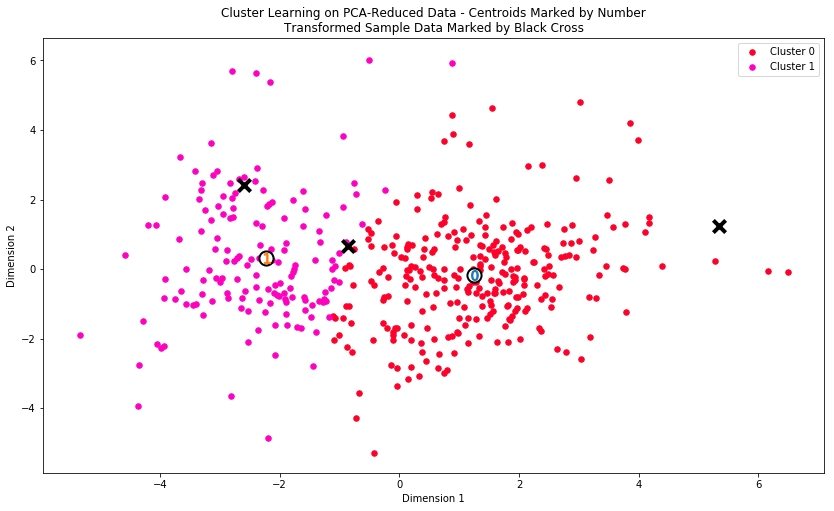

In [25]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [26]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

Fresh    Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
Segment 0  8953.0  2114.0   2765.0  2075.0             353.0         732.0
Segment 1  3552.0  7837.0  12219.0   870.0            4696.0         962.0

In [27]:
display(data.describe())

Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper  Delicatessen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%         3922.000000   1820.250000  
max        40827.000000  47943.000000

### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. Think about what each segment represents in terms their values for the feature points chosen. Reference these values with the mean values to get some perspective into what kind of establishment they represent.

**Answer:**

The mean for the original dataset is shown above compared to the cluster centers. 

**Segment 0** has an above mean spend on `Milk` and `Grocery` and `Detergents_Paper`. The spend on `Fresh` and `Delicatessen` is below the mean. This spending combination could be representative of a retailer or supermarket who are likely to spend more on these daily good. 

**Segment 1** has a higher spend on `Fresh` and `Frozen` and purchases significantly less `Detergents_Paper`/`Milk`/`Grocery` than Segment 0. This is more indicative of a Cafe/Restaraunt type establishment who cook with more Fresh and Frozen ingredients. 


### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [28]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


**Answer:**

| Original index | Original Prediction | Prediction based on Segment/Cluster |
| --- | --- | --- |
| Index 8 (sample point 0) | Retail shop (supermarket) | Cluster 0 (supermarket/retailer) |
| Index 53 (sample point 1) | Cafe | Cluster 0 (supermarket/retailer) |
| Index 289 (sample point 2) | Restaraunt  | Cluster 1 (Cafe/Restaurant)|

My predictions were correct apart from sample point 1. It is clear from the cluster representation above however that this point sits on the boundary of the two clusters so it is no suprise that it could be mis-classified based on my original predicitons as it is on the edge of a cluster. 


## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

Customers with different needs will respond differently to the changes from the delivery service from 5 days a week to 3 days a week. Customers with high amount of perishable fresh good may react more negatively to these changes for example. Segment 1 have a higher spend on Fresh ingredients so it could be assumed that they may react more negatively. Equally Segment 0 have a higher spend on Milk which is also perishable so the same logic may apply here.

In order to determine this we could use A/B testing. We have defined the two clusters above. We could take a sample of 20 from each of the cluster and change the delivery schedule. We would then do a survey and based on these results we could determine if a certain Segment of users reacted positively to the change before rolling it out to more customers in that Segment. 

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

The clustering methodolgy is an unsupervised learning method. Once we have applied the clusters to obtain some structure in the data we could then use the output of the `Customer Segment` data for Segment 0 and Segment 1 and use this as the target value in a supervised learning methodology against the original features. This could then be used to train the model along with the normal training and testing methodology. Using the model we can then predict for new values given there estimate product spending if the customer would fall into Segment 0 and Segment 1. 

Unsupervised learning is used when we want to learn more about the structure of the data. If we have a deeper undesrtanding of the customer requirements we could instead use supervised learning against pre-labelled data. We could use the feature `Channel` in the original dataset if we knew this was representative. 

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

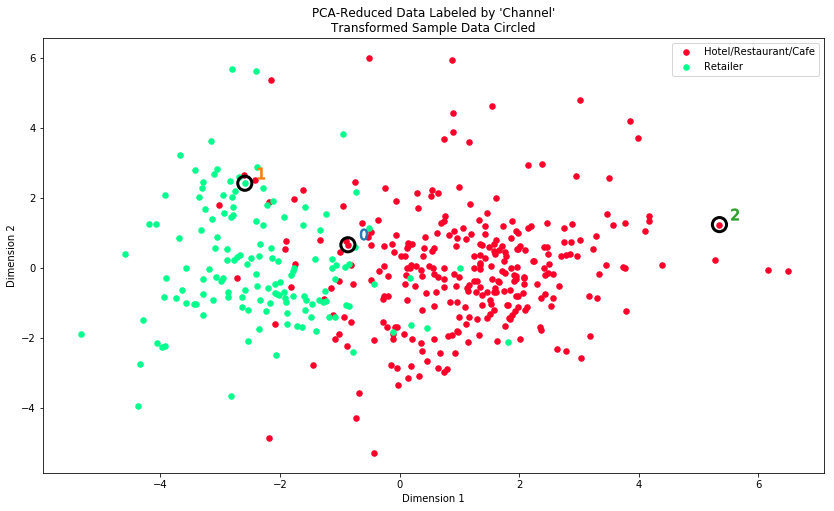

In [29]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers_to_remove, pca_samples)

In [33]:
# Show the accuracy
channel_labels = pd.read_csv("customers.csv")["Channel"]
channel_labels = channel_labels.drop(channel_labels.index[outliers_to_remove]).reset_index(drop = True) - 1
# channel_labels = abs(channel_labels -1)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(channel_labels,preds)
print(accuracy)

0.9011494252873563


### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

* The `Hotel/Restaurant/Cafe` and `Retailer` clusters above closely match the two clusters or customer segments generated using the clustering algorthim. 
* There are clear clusters generated above with the Retailers forming a distinct cluster from Hotel/Restaurant/Cafe.
* The classifications are consistant with the previous definition. There are some points that could be misclassified towards the boundries of the clusters but this is normal. 